# Deep Linear Networks

Here, we repeat the experiments by [Jacot et al. (2022)](https://arxiv.org/abs/2106.15933), then [estimate SLT-derived invariants like the learning coefficient](https://github.com/edmundlth/scalable_learning_coefficient_with_sgld/blob/v1.0/experiment.py).

Currently, this only looks at the learning task behind figure 3 (not the MC loss behind figure 2).

A **deep linear network** (DLN) of length $L$ is a neural network with $L$ layers of widths $n_0, \dots, n_L$, that computes the transformation:

$$
\begin{align}
f: \mathbb{R}^{n_0} &\to \mathbb{R}^{n_L} \\
x &\mapsto W_L \cdots W_1 x =: A_\theta x,
\end{align}
$$

Parametrized by $\theta \in \mathbb{R}^P$, where $P = \sum_{l=1}^L n_{l-1} n_l$ is the number of parameters.

For convenience, we consider **rectangular networks**, or $(L, w)$-DLNs, with constant hidden width $w$ across all layers: $n_1 = \dots = n_{L-1} = w$.

## Hyperparameters

- $L$ is the number of layers
- $N=n_0$ is the input dimension
- $M=n_L$ is the output dimension
- $r$ is the rank of the "true" matrix / teacher $A^*$
- $w$ or $H$ is the hidden width (for rectangular networks).
- $\sigma$ is the teacher's output noise. By default, we use $\sigma=0$.


# Set-up

- For the definition of the model `DLN`, a `torch.nn.Module`, see `devinterp.zoo.dln.model`.
- For the definition of the dataset `DLNDataset`, a `torch.utils.data.Dataset`, see `devinterp.zoo.dln.dataset`.

## Imports

In [12]:
from typing import Optional, Union, List
from dataclasses import dataclass, field
import itertools
import yaml 
import logging

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy
from typing import Any, Type 
import seaborn

from devinterp.slt.ensemble import Ensemble
from devinterp.slt.sampler import estimate_rlct
from devinterp.optim.optimizers import OptimizerConfig
from devinterp.optim.sgld import SGLD
from devinterp.learner import LearnerConfig
from devinterp.evals import CombineEvaluators, MSEEvaluator, RepeatEvaluator, EvaluatorWrapper
from devinterp.utils import get_default_device

from devinterp.zoo.dlns.model import DLN
from devinterp.zoo.dlns.data import DLNDataset

device = get_default_device()
logging.basicConfig(level=logging.INFO)

In [54]:
import itertools
import multiprocessing
from copy import deepcopy
from dataclasses import dataclass
from functools import partial
from logging import Logger
from typing import Callable, Dict, List, Literal, Optional, Union

import numpy as np
import pandas as pd
import torch
import yaml
from torch import nn
from torch.multiprocessing import Pool, cpu_count
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.slt.observables import MicroscopicObservable
from devinterp.utils import Criterion


def sample_single_chain(
    ref_model: nn.Module,
    loader: DataLoader,
    criterion: Callable,
    num_draws=100,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    step: Literal["sgld"] = "sgld",
    optimizer_kwargs: Optional[Dict] = None,
    chain: int = 0,
    seed: Optional[int] = None,
    pbar: bool = False,
    observor: Optional[MicroscopicObservable] = None,
    device: torch.device = torch.device("cpu"),
):
    # Initialize new model and optimizer for this chain
    model = deepcopy(ref_model).to(device)

    if step == "sgld":
        optimizer_kwargs = optimizer_kwargs or {}
        optimizer = SGLD(
            model.parameters(), **optimizer_kwargs
        )  # Replace with your actual optimizer kwargs

    if seed is not None:
        torch.manual_seed(seed)

    num_steps = num_draws * num_steps_bw_draws + num_burnin_steps
    local_draws = pd.DataFrame(index=range(num_draws), columns=["chain", "loss"])

    iterator = zip(range(num_steps), itertools.cycle(loader))

    if pbar:
        iterator = tqdm(iterator, desc=f"Chain {chain}", total=num_steps)

    model.train()

    for i, (xs, ys) in iterator:
        optimizer.zero_grad()
        xs, ys = xs.to(device), ys.to(device)
        y_preds = model(xs)
        loss = criterion(y_preds, ys)
        loss.backward()
        optimizer.step()

        if i >= num_burnin_steps and (i - num_burnin_steps) % num_steps_bw_draws == 0:
            draw_idx = (i - num_burnin_steps) // num_steps_bw_draws
            local_draws.loc[draw_idx, "chain"] = chain
            local_draws.loc[draw_idx, "loss"] = loss.detach().item()

    return local_draws



def _sample_single_chain(kwargs):
    return sample_single_chain(**kwargs)


def sample(
    model: torch.nn.Module,
    loader: DataLoader,
    criterion: torch.nn.Module,
    step: Literal["sgld"],
    optimizer_kwargs: Optional[Dict[str, Union[float, Literal["adaptive"]]]] = None,
    num_draws: int = 100,
    num_chains: int = 10,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    cores: Optional[int] = 1,
    seed: Optional[Union[int, List[int]]] = None,
    pbar: bool = True,
    device: torch.device = torch.device("cpu"),
):
    """
    Sample model weights using a given optimizer, supporting multiple chains.

    Parameters:
        model (torch.nn.Module): The neural network model.
        step (Literal['sgld']): The name of the optimizer to use to step.
        loader (DataLoader): DataLoader for input data.
        criterion (torch.nn.Module): Loss function.
        num_draws (int): Number of samples to draw.
        num_chains (int): Number of chains to run.
        num_burnin_steps (int): Number of burn-in steps before sampling.
        num_steps_bw_draws (int): Number of steps between each draw.
        cores (Optional[int]): Number of cores for parallel execution.
        seed (Optional[Union[int, List[int]]]): Random seed(s) for sampling.
        progressbar (bool): Whether to display a progress bar.
        optimizer_kwargs (Optional[Dict[str, Union[float, Literal['adaptive']]]]): Keyword arguments for the optimizer.
    """
    if cores is None:
        cores = min(4, cpu_count())

    if seed is not None:
        if isinstance(seed, int):
            seeds = [seed + i for i in range(num_chains)]
        elif len(seed) != num_chains:
            raise ValueError("Length of seed list must match number of chains")
        else:
            seeds = seed
    else:
        seeds = [None] * num_chains

    def get_args(i):
        return dict(
            chain=i,
            seed=seeds[i],
            ref_model=model,
            loader=loader,
            criterion=criterion,
            num_draws=num_draws,
            num_burnin_steps=num_burnin_steps,
            num_steps_bw_draws=num_steps_bw_draws,
            step=step,
            optimizer_kwargs=optimizer_kwargs,
            pbar=pbar,
            device=device,
        )

    results = []
    
    if cores > 1:
        if str(device) == "cpu":
            with Pool(cores) as pool:
                results = pool.map(
                    _sample_single_chain, [get_args(i) for i in range(num_chains)]
                )
        else:
            raise NotImplementedError("Cannot currently use multiprocessing with GPU")
    else:
        for i in range(num_chains):
            results.append(_sample_single_chain(get_args(i)))

    results_df = pd.concat(results, ignore_index=True)
    return results_df


def estimate_rlct(
    model: torch.nn.Module,
    loader: DataLoader,
    criterion: Criterion,
    step: Literal["sgld"],
    optimizer_kwargs: Optional[Dict[str, Union[float, Literal["adaptive"]]]] = None,
    num_draws: int = 100,
    num_chains: int = 10,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    cores: Optional[int] = 1,
    seed: Optional[Union[int, List[int]]] = None,
    pbar: bool = True,
    baseline: Literal["init", "min"] = "init",
    device: torch.device = torch.device("cpu"),
) -> float:
    trace = sample(
        model=model,
        loader=loader,
        criterion=criterion,
        step=step,
        optimizer_kwargs=optimizer_kwargs,
        num_draws=num_draws,
        num_chains=num_chains,
        num_burnin_steps=num_burnin_steps,
        num_steps_bw_draws=num_steps_bw_draws,
        cores=cores,
        seed=seed,
        pbar=pbar,
        device=device,
    )

    if baseline == "init":
        baseline_loss = trace.loc[trace["chain"] == 0, "loss"].iloc[0]
    elif baseline == "min":
        baseline_loss = trace["loss"].min()

    avg_loss = trace.groupby("chain")["loss"].mean().mean()
    num_samples = len(loader.dataset)

    return (avg_loss - baseline_loss) * num_samples / np.log(num_samples)


In [55]:
import functools

from devinterp.evals import clean_evals_results


class RectangularDLNConfig(LearnerConfig):
    teacher_matrix: torch.Tensor
    gamma: float = 1.
    w: int = 100
    L: int = 4
    seed: int = 0

    noise_level: float = 1.

    class Config:
        arbitrary_types_allowed=True

    def create_teacher(self):
        return DLN.from_matrix(self.teacher_matrix, L=1)
    
    def create_student(self):
        return DLN.make_rectangular(input_dim=self.input_dim, output_dim=self.output_dim, L=self.L, w=self.w, gamma=self.gamma)
        
    def create_data(self, teacher: DLN):
        return DLNDataset.generate_split(teacher, self.num_training_samples, self.noise_level, self.seed)

    @property
    def input_dim(self):
        return self.teacher_matrix.shape[1]
    
    @property
    def output_dim(self):
        return self.teacher_matrix.shape[0]
    
    def model_dump(self, *args, **kwargs):
        dump = super().model_dump(*args, **kwargs)
        dump["teacher_matrix"] = self.teacher_matrix.tolist()

        return dump    

def make_evals(teacher_matrix: torch.Tensor, trainset: DLNDataset, testset: DLNDataset, device: torch.device):
    teacher_matrix = teacher_matrix.to(device)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    def eval_progress(model: DLN):
        # Divide the first singular value by the first singular value of the teacher, and so on, then sum.
        # This needs a new name.
        singular_values = model.to_matrix().to("cpu").svd().S
        teacher_singular_values = teacher_matrix.to("cpu").svd().S
        missing_singular_values = teacher_singular_values == 0
        teacher_singular_values[missing_singular_values] = 1
        progress = (singular_values / teacher_singular_values)
        # Get rid of division by zero problems
        progress[progress == np.inf] = 0
        progress[progress == -np.inf] = 0
        progress[missing_singular_values] = 0

        return {"progress": torch.sum(progress).item()}
    
    def matrix_evals(model: DLN):
        return clean_evals_results({
            "rank": model.rank(atol=1e-1),
            "ranks": model.ranks(atol=1e-1),
            "grad_norm": model.grad_norm(),
            "nuc_norm": model.norm(p="nuc"),
            "nuc_norms": model.norms(p="nuc")
        })
    
    def eval_rlct(model: DLN):
        model.to("cpu")
        rlct = estimate_rlct(
            model,
            loader=trainloader,
            criterion=F.mse_loss,
            step='sgld',
            optimizer_kwargs=dict(lr=1e-4, temperature="adaptive", num_samples=len(trainset)),
            num_draws=20,
            num_chains=5,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            cores=1,
            pbar=False,
            baseline="init",
            device=torch.device("cpu")
        )
        model.to(device)
        return {"rlct": rlct}

    return CombineEvaluators([
        MSEEvaluator(train=trainloader, test=testloader, device=device),   
        eval_progress,
        matrix_evals,        
        RepeatEvaluator(eval_rlct, 5)
    ])


def create_dln_learner(config: RectangularDLNConfig):
    teacher = config.create_teacher()
    student = config.create_student()
    trainset, testset = config.create_data(teacher)
    evals = make_evals(teacher_matrix, trainset, testset, config.device)
    learner = config.factory(student, trainset, evals)
    return learner

NUM_STEPS = 10_000

teacher_matrix = 10. * torch.Tensor(np.diag([1, 2, 3, 4, 5])).detach()
config = RectangularDLNConfig(
    teacher_matrix=teacher_matrix,
    num_training_samples=1024,
    batch_size=128,
    num_steps=NUM_STEPS,
    logger_config=dict(
        logging_steps={
            "log_space": 100,
            "lin_space": 100,
        },
        # stdout=True,
        use_df=True,
        # out_file="./dlns.csv"
    ),
    checkpointer_config={},
    optimizer_config=dict(
        optimizer_type="SGD",
        lr=1e-3,
        momentum=0.9,
        weight_decay=1e-3,
    ),
    w=100,
    L=4,
    criterion="mse_loss",
    gamma=1.,
    noise_level=0.,
    device=str(device)
)

INFO:devinterp.learner:Logging to wandb disabled
INFO:devinterp.learner:L: 4
batch_size: 128
checkpointer_config:
  bucket_name: null
  device: cpu
  local_root: null
  project_dir: checkpoints
criterion: mse_loss
device: mps
gamma: 1.0
logger_config:
  entity: null
  out_file: null
  project: null
  run_id: null
  stdout: false
  use_df: true
noise_level: 0.0
num_steps: 10000
num_training_samples: 1024
optimizer_config:
  betas: null
  elasticity: null
  lr: 0.001
  momentum: 0.9
  noise_level: null
  num_samples: null
  optimizer_type: SGD
  temperature: null
  weight_decay: 0.001
scheduler_config: null
seed: 0
teacher_matrix:
- - 10.0
  - 0.0
  - 0.0
  - 0.0
  - 0.0
- - 0.0
  - 20.0
  - 0.0
  - 0.0
  - 0.0
- - 0.0
  - 0.0
  - 30.0
  - 0.0
  - 0.0
- - 0.0
  - 0.0
  - 0.0
  - 40.0
  - 0.0
- - 0.0
  - 0.0
  - 0.0
  - 0.0
  - 50.0
w: 100



In [56]:
learner = create_dln_learner(config)
learner.train()

Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/Jesse/Projects/devinterp/devinterp/ops/logging.py:149: UserWarning: Step 9999 not in logging_steps. Ignoring.
  warnings.warn(warning)


In [57]:
df = learner.logger.loggers[0].df
df.sort_values("step", inplace=True)

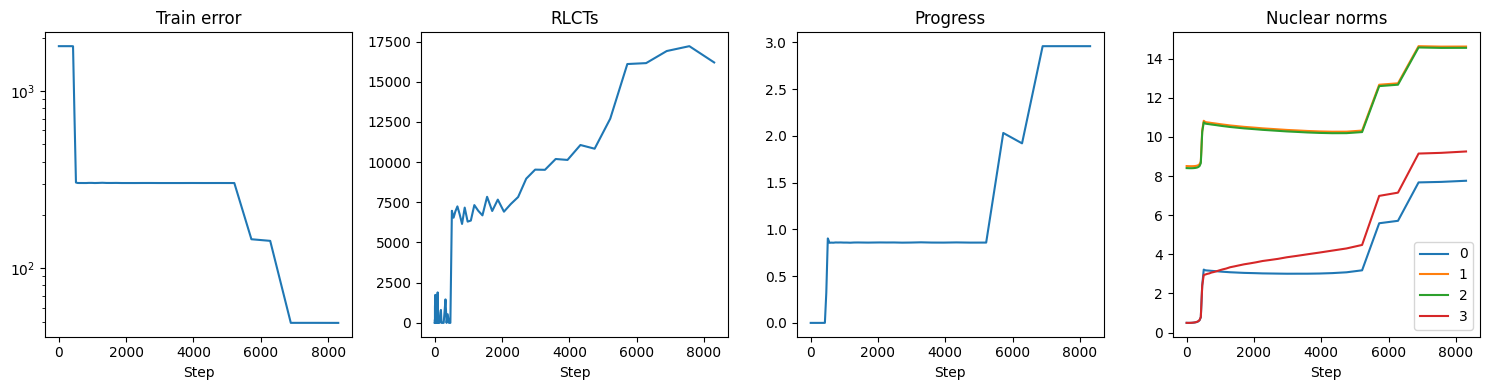

In [58]:
# Visualizing runs

def plot_all(run: Run, xlog=False, figsize=(15, 4), title=None, smooth_rlcts=0):
    fig, ax1 = plt.subplots(figsize=figsize)

    num_steps = run.num_steps

    ax1.set_title(title if title else "Combined Plot")
    ax1.set_xlabel("Step")
    if xlog:
        ax1.set_xscale("log")

    # Train error
    ax1.plot(np.arange(num_steps), run.train_errors, label="Train error", color="b")
    ax1.set_yscale("log")
    ax1.set_ylabel("Train error", color="b")
    ax1.tick_params(axis='y', labelcolor="b")

    # RLCTs
    ax2 = ax1.twinx()
    rlcts = np.clip(run.rlcts, 0, None)
    if smooth_rlcts:
        rlcts = np.concatenate([[rlcts[0]] * smooth_rlcts, rlcts, [rlcts[-1]] * smooth_rlcts])
        rlcts = np.convolve(rlcts, np.ones(smooth_rlcts) / smooth_rlcts, mode="same")
        rlcts = rlcts[smooth_rlcts:-smooth_rlcts]
    ax2.plot(np.linspace(0, num_steps, len(rlcts)), rlcts, label="RLCTs", color="g")
    ax2.set_ylabel("RLCTs", color="g")
    ax2.tick_params(axis='y', labelcolor="g")

    # Effective Rank
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(np.arange(0, num_steps, 100), run.eff_ranks, label="Effective rank", color="r")
    ax3.set_ylabel("Effective Rank", color="r")
    ax3.tick_params(axis='y', labelcolor="r")

    # Nuclear Norms
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))
    for l in range(run.L):
        ax4.plot(np.arange(0, num_steps, 100), [e[l] for e in run.sub_nuc_norms], label=f"Nuclear Norm {l}")
    ax4.set_ylabel("Nuclear Norms")
    ax4.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

    plt.tight_layout()
    plt.show()


def plot_all_v1(run: Run, xlog=False, figsize=(15, 4), title=None, smooth_rlcts=0):
    num_steps = run.num_steps

    fig, axes = plt.subplots(1, 4, figsize=figsize)

    axes[0].set_title("Train error")
    axes[0].plot(steps, df["train/mse"], label="Train")
    axes[0].set_yscale("log")

    # clip to positive values
    rlcts = np.clip(df["rlct/mean"], 0, None)

    # rlcts = sample_run.rlcts
    axes[1].set_title("RLCTs")
    axes[1].plot(steps, rlcts, label="RLCT")
    # axes[1].set_yscale("log")

    axes[2].set_title("Progress")
    axes[2].plot(steps, df["progress"], label="Grad norm")

    # plt.title("Subranks")
    # for l in range(run.L):
    #     plt.plot(np.arange(0, num_steps, 100), [e[l] for e in run.subranks], label=str(l))
    # # plt.yscale("log")
    # plt.legend()
    # plt.show()
    L = 4
    axes[3].set_title("Nuclear norms")
    for i in range(L):
        axes[3].plot(steps, df[f"nuc_norms/{i}"], label=str(i))
    # axes[3].set_yscale("log")
    axes[3].legend()

    for ax in axes:
        ax.set_xlabel("Step")
        if xlog:
            ax.set_xscale("log")

    if title is not None:
        fig.suptitle(title)
    
    plt.tight_layout()
    plt.show()

plot_all(df, xlog=False, smooth_rlcts=100)

# Experiments

In [9]:
# Defining all the teacher matrices

# Rank 5
rk5_matrix = torch.Tensor(10 * np.diag(np.arange(1, 6)))
set_seed(0)
rk5_task = Task(rk5_matrix)
set_seed(0)
rk5_err2_task = Task(rk5_matrix, noise_level=10)

# Rank 4
rk4_matrix = rk5_matrix.clone()
rk4_matrix[-1, -1] = 0
set_seed(0)
rk4_task = Task(rk4_matrix)
set_seed(0)
rk4_err2_task = Task(rk4_matrix, noise_level=10)

# Rank 2
rk2_matrix = rk4_matrix.clone()
rk2_matrix[-2, -2] = 0
rk2_matrix[-3, -3] = 0
set_seed(0)
rk2_task = Task(rk2_matrix)
set_seed(0)
rk2_err2_task = Task(rk2_matrix, noise_level=10)

sgld_config = OptimizerConfig(
    optimizer_type="SGLD",
    lr=1e-5,
    noise_level=0.5,
    weight_decay=0.,
    elasticity=1.,
    temperature='adaptive',
    num_samples=100,
)

sampler_config = SamplerConfig(
    optimizer_config=sgld_config,
    num_chains=50,
    num_draws_per_chain=20,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    batch_size=256,
)

sampler_config.optimizer_config = sgld_config

opt_config = OptimizerConfig(
    optimizer_type="SGD",
    lr=1e-3,
    momentum=0.9,
    weight_decay=1e-3,
)

default_kwargs = {"num_steps": 10_000, "gamma": 1.1, "opt_config": opt_config, "sampler_config": sampler_config} # Gamma > 1 puts us slightly in the saddle-to-saddle regime

tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0., 50.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0., 50.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
tensor([[10.,  0.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  

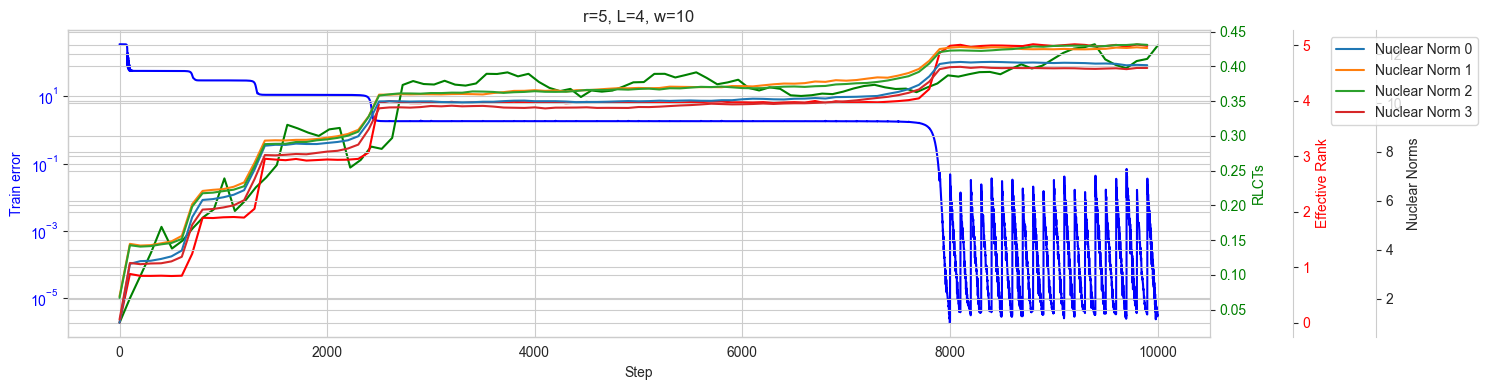

In [13]:
# run_rk5_L4_w10 = fit(rk5_task, w=10, L=4, **default_kwargs)
plot_all(run_rk5_L4_w10, xlog=False, title="r=5, L=4, w=10", smooth_rlcts=5)

batch_size: 256
num_burnin_steps: 0
num_chains: 50
num_draws_per_chain: 20
num_steps_bw_draws: 1
optimizer_config:
  betas: null
  elasticity: 1.0
  lr: 1.0e-05
  momentum: null
  noise_level: 0.5
  num_samples: 100
  optimizer_type: SGLD
  temperature: adaptive
  weight_decay: 0.0
verbose: false



Training:   0%|          | 0/10000 [00:00<?, ?it/s]

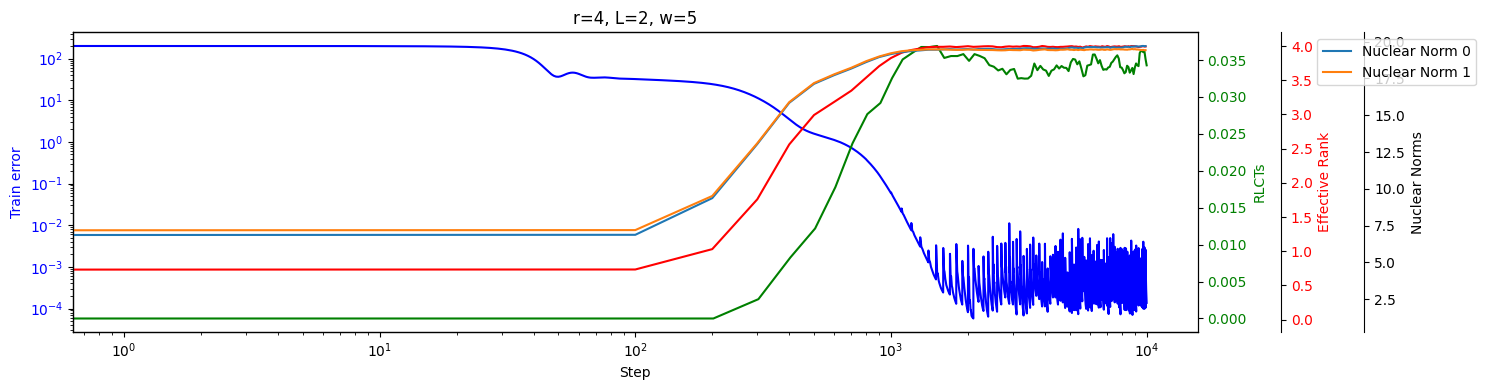

batch_size: 256
num_burnin_steps: 0
num_chains: 50
num_draws_per_chain: 20
num_steps_bw_draws: 1
optimizer_config:
  betas: null
  elasticity: 1.0
  lr: 1.0e-05
  momentum: null
  noise_level: 0.5
  num_samples: 100
  optimizer_type: SGLD
  temperature: adaptive
  weight_decay: 0.0
verbose: false



Training:   0%|          | 0/10000 [00:00<?, ?it/s]

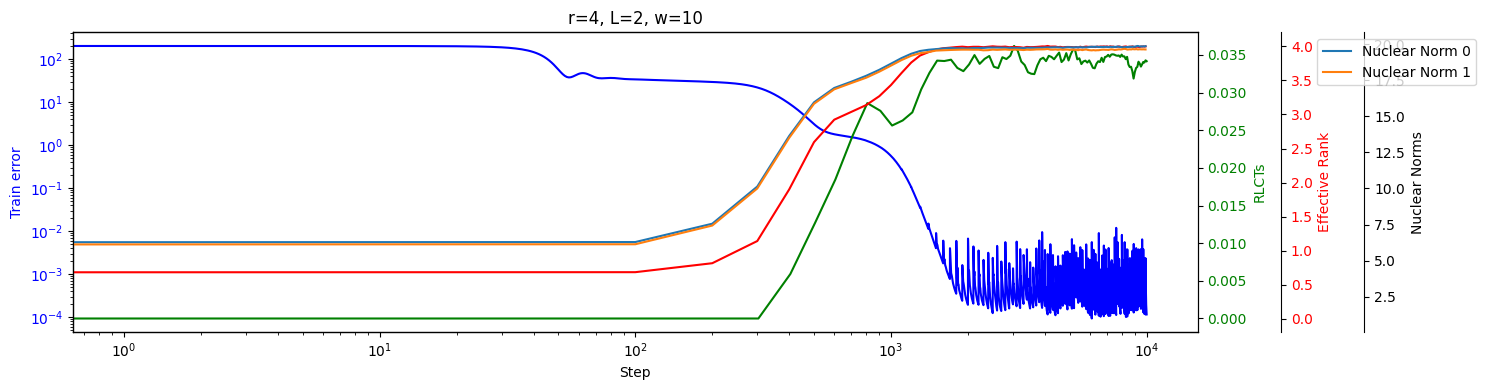

In [11]:
run_rk4_L2_w5 = fit(rk4_task, w=5, L=2, **default_kwargs)
plot_all(run_rk4_L2_w5, xlog=True, title="r=4, L=2, w=5", smooth_rlcts=5)

run_rk4_L2_w10 = fit(rk4_task, w=10, L=2, **default_kwargs)
plot_all(run_rk4_L2_w10, xlog=True, title="r=4, L=2, w=10", smooth_rlcts=5)

In [ ]:
run_rk4_err2_L2_w5 = fit(rk4_err2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk4_err2_L2_w5, xlog=True, title="r=4, L=2, w=10, noise=10", smooth_rlcts=5)

run_rk4_err2_L2_w10 = fit(rk4_err2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk4_err2_L2_w10, xlog=True, title="r=4, L=2, w=10, noise=10", smooth_rlcts=5)

NameError: name 'fit' is not defined

In [ ]:
# N = 5, Rank = 2, L = 2 (1 hidden state)
run_rk2_L2_w5 = fit(rk2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk2_L2_w5, xlog=False, title="r=2, L=2, w=5", smooth_rlcts=5)

run_rk2_L2_w10 = fit(rk2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk2_L2_w10, xlog=False, title="r=2, L=2, w=10", smooth_rlcts=5)

NameError: name 'fit' is not defined

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

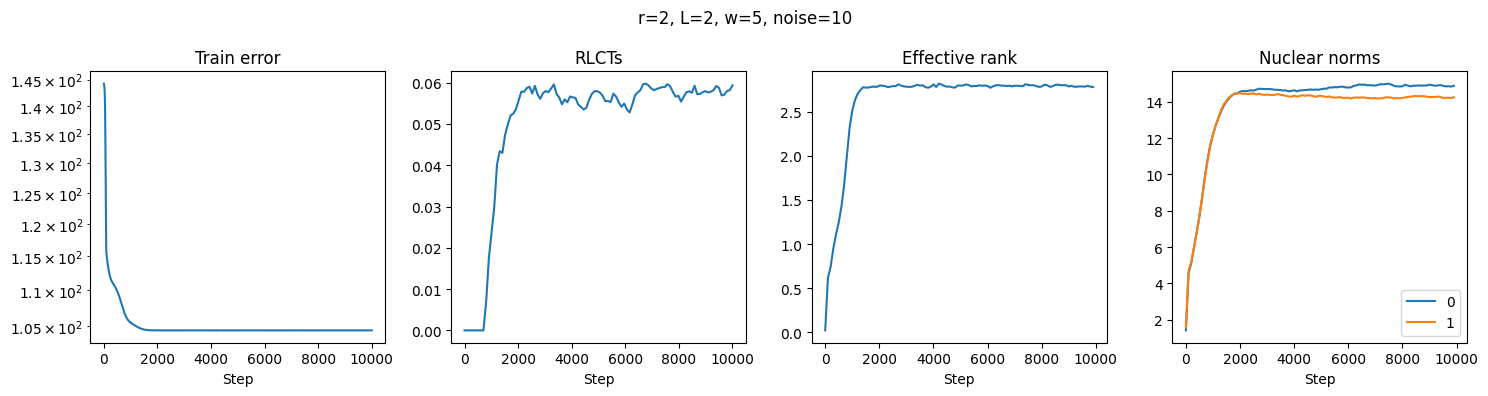

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

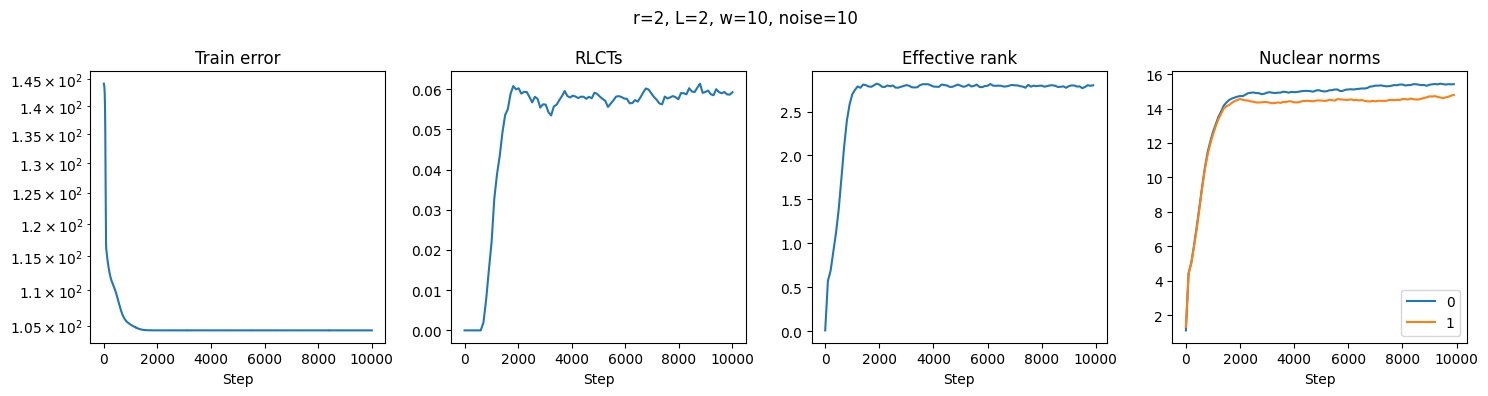

In [ ]:
# N = 5, Rank = 2, L = 2 (1 hidden state)
run_rk2_err2_L2_w5 = fit(rk2_err2_task, w=5, L=2, **default_kwargs)
plot_all(run_rk2_err2_L2_w5, xlog=False, title="r=2, L=2, w=5, noise=10", smooth_rlcts=5)

run_rk2_err2_L2_w10 = fit(rk2_err2_task, w=10, L=2, **default_kwargs)
plot_all(run_rk2_err2_L2_w10, xlog=False, title="r=2, L=2, w=10, noise=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

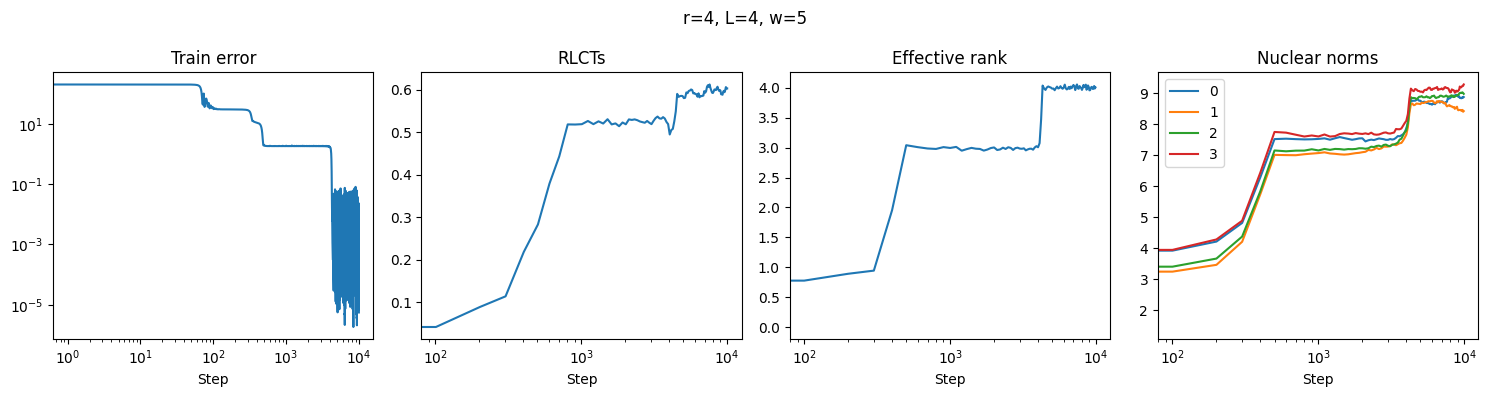

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

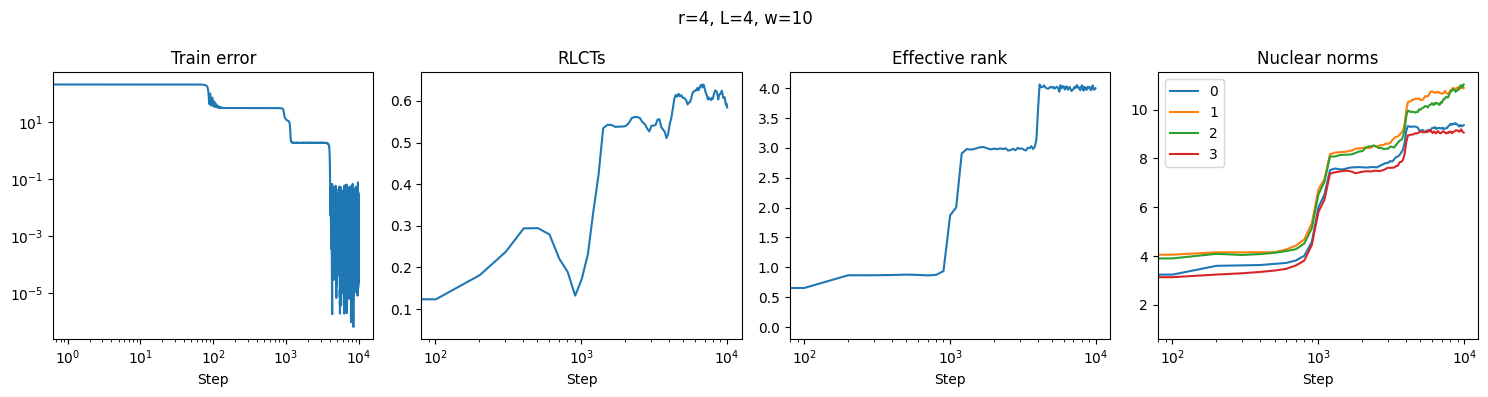

In [ ]:
run_rk4_L4_w5 = fit(rk4_task, w=5, L=4, **default_kwargs)
plot_all(run_rk4_L4_w5, xlog=True, title="r=4, L=4, w=5", smooth_rlcts=5)

run_rk4_L4_w10 = fit(rk4_task, w=10, L=4, **default_kwargs)
plot_all(run_rk4_L4_w10, xlog=True, title="r=4, L=4, w=10", smooth_rlcts=5)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

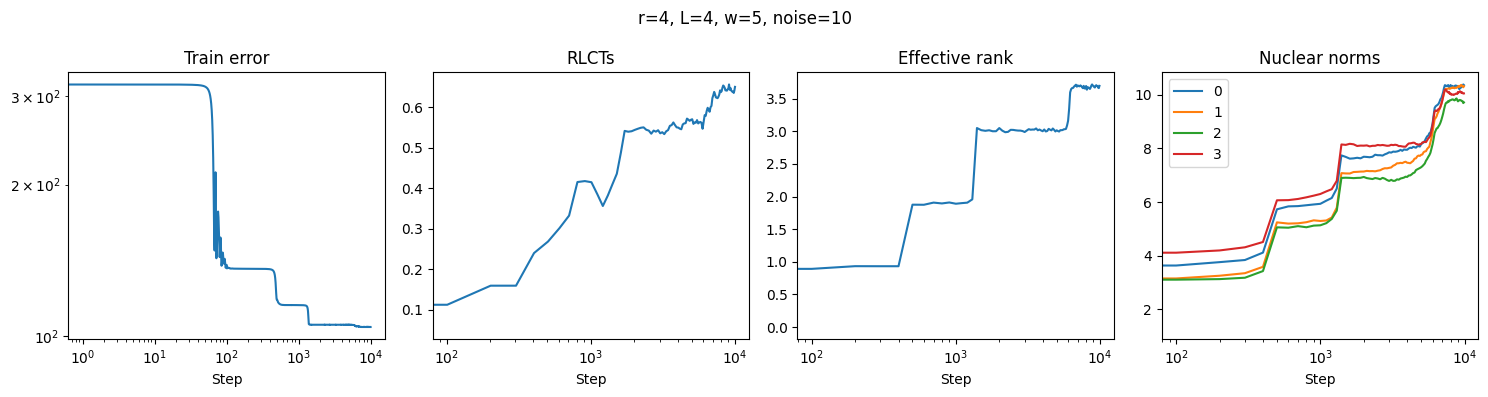

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

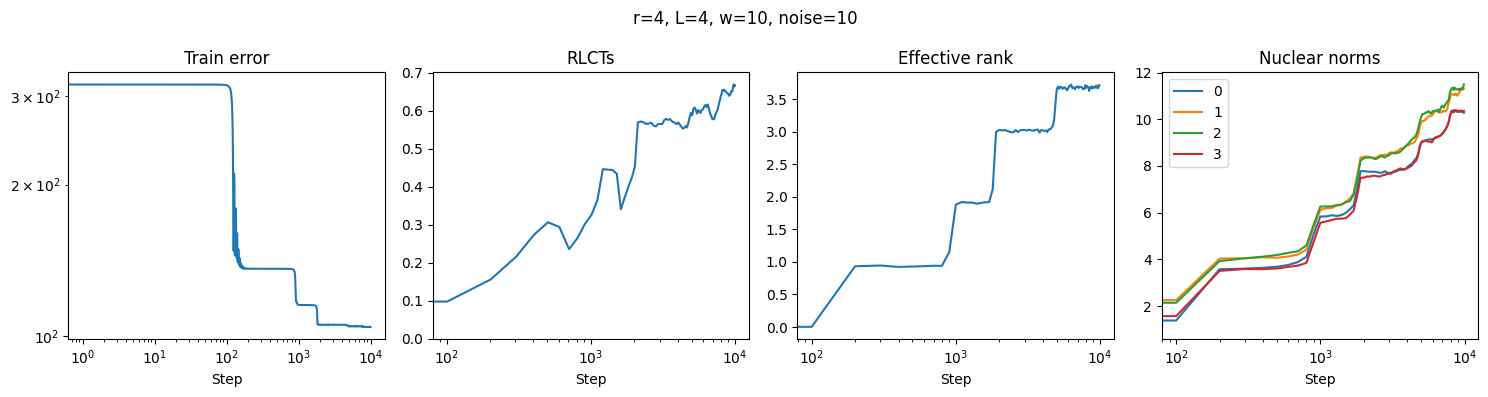

In [ ]:
run_rk4_err2_L4_w5 = fit(rk4_err2_task, w=5, L=4, **default_kwargs)
plot_all(run_rk4_err2_L4_w5, xlog=True, title="r=4, L=4, w=5, noise=10", smooth_rlcts=5)

run_rk4_err2_L4_w10 = fit(rk4_err2_task, w=10, L=4, **default_kwargs)
plot_all(run_rk4_err2_L4_w10, xlog=True, title="r=4, L=4, w=10, noise=10", smooth_rlcts=5)

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

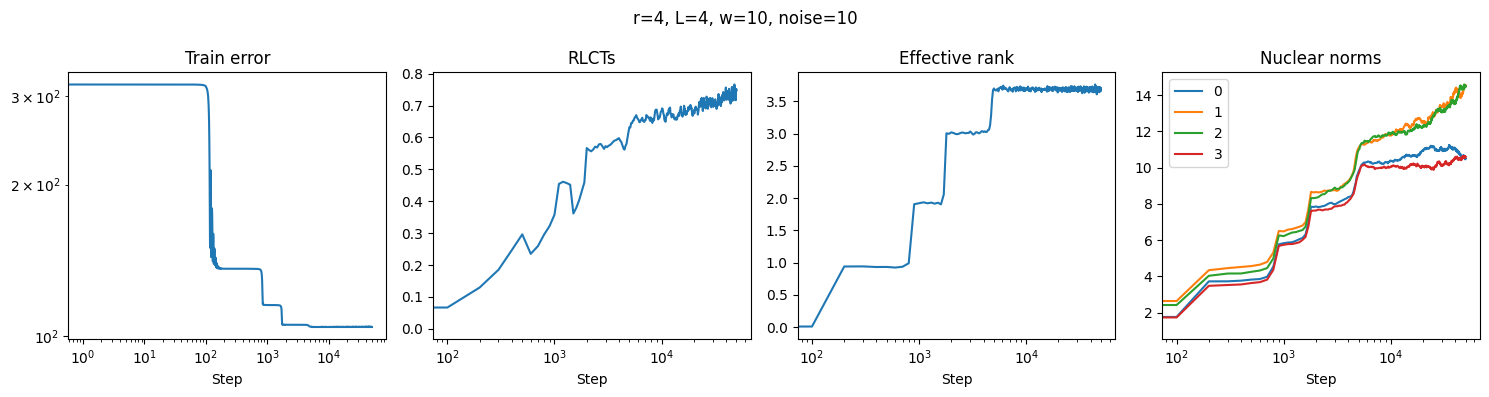

In [ ]:
kwargs = default_kwargs.copy()
kwargs["num_steps"] = 50_000

run_rk4_err2_L4_w10 = fit(rk4_err2_task, w=10, L=4, **kwargs)
plot_all(run_rk4_err2_L4_w10, xlog=True, title="r=4, L=4, w=10, noise=10", smooth_rlcts=5)


# Recreate figure 5

In [ ]:
@dataclass
class Runs:
    runs: List[Run] = field(default_factory=list)

    def filter(self, **kwargs):
        return Runs([run for run in self.runs if self.matches(run, **kwargs)])

    @staticmethod
    def matches(run, **kwargs):
        return all([getattr(run, k) == v for k, v in kwargs.items()])
    
    def __iter__(self):
        return iter(self.runs)
    
    def __len__(self):
        return len(self.runs)
    
    def __getitem__(self, i):
        return self.runs[i]
    
    def __repr__(self):
        return f"Runs({self.runs})"
    
    def __add__(self, other):
        return Runs(self.runs + other.runs)
    
    def __iadd__(self, other):
        self.runs += other.runs
        return self
    
    def append(self, run):
        self.runs.append(run)

runs = Runs()


# Define a unique set of gammas
gammas = [0.75, 1., 1.5]
ws = [10, 100]

for gamma, w in tqdm(list(itertools.product(gammas, ws)), desc="Sweeping"):
    runs.append(fit(train_loader, gamma=gamma, w=w))


Sweeping:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

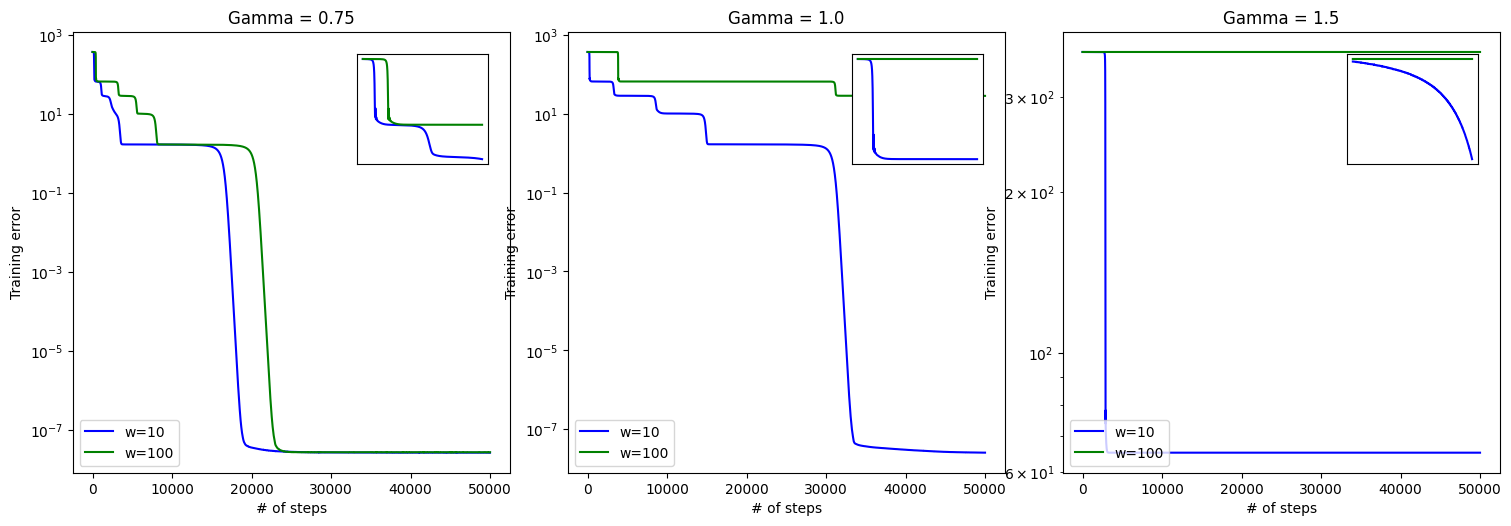

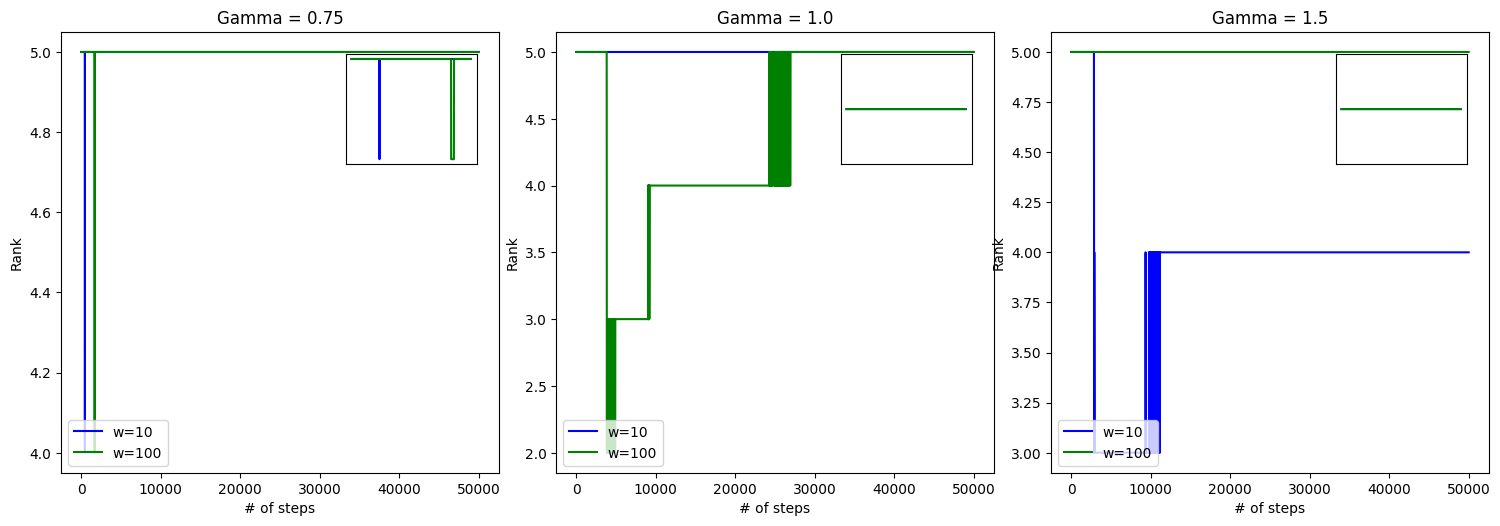

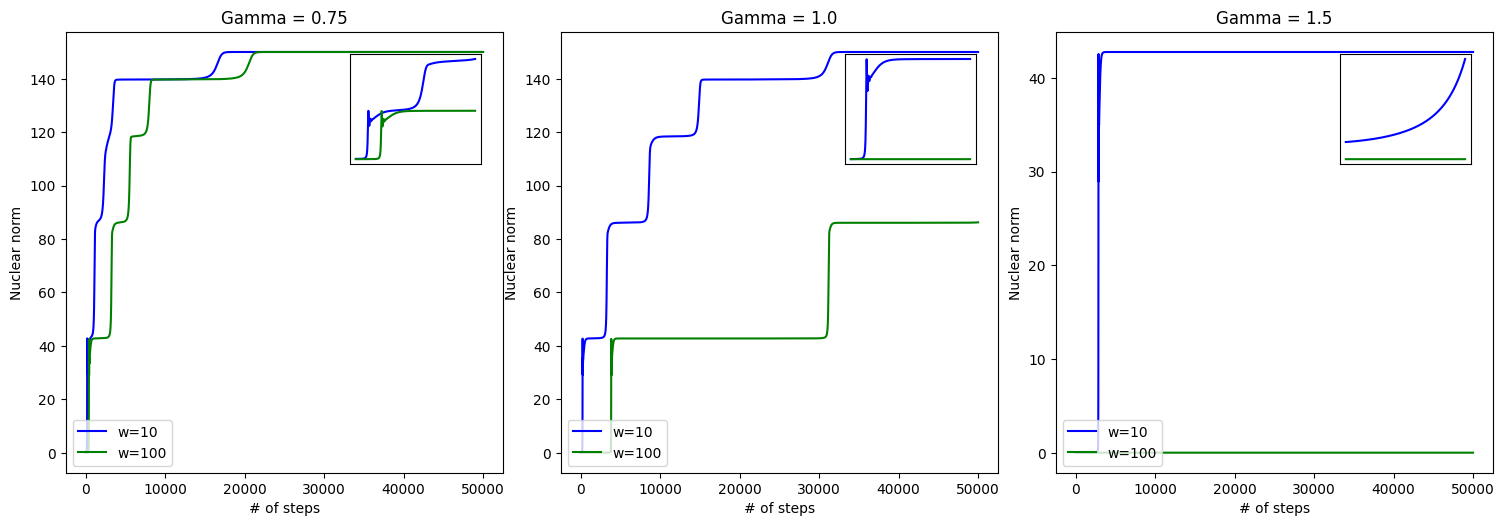

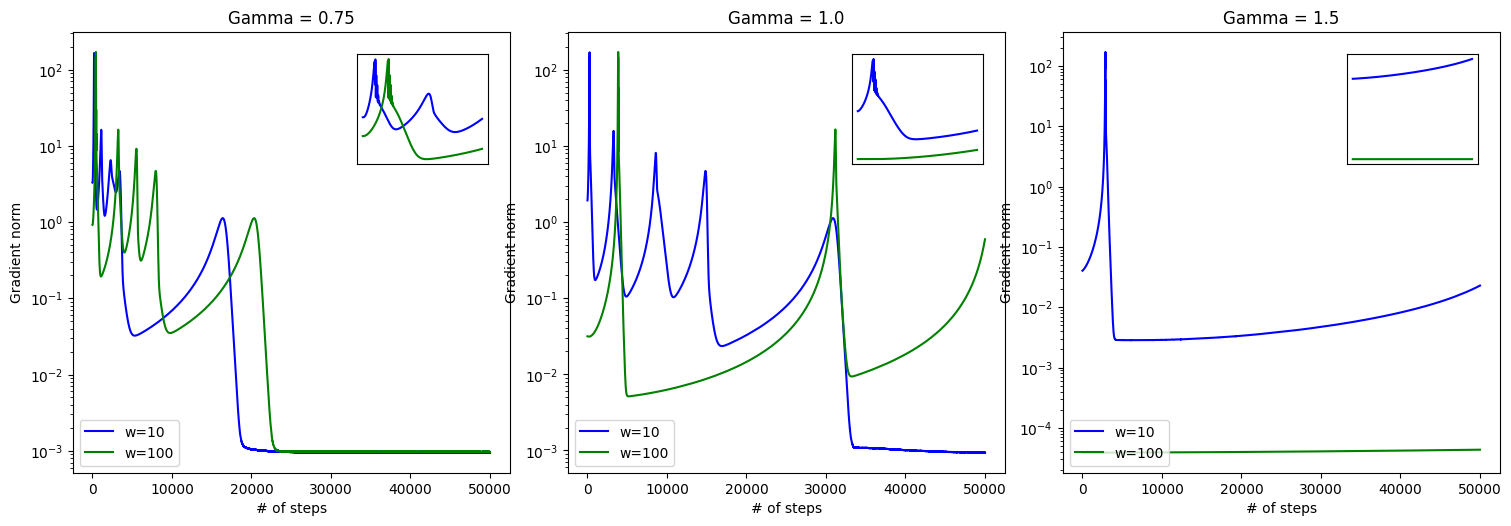

In [ ]:
import matplotlib.pyplot as plt

def plot(runs: Runs, metric: str, ylabel: str, title: str, logscale: bool = False):

    # Define the colors for each w value
    colors = {10: 'b', 100: 'g'}

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    fig.tight_layout()


    # Iterate through the unique gammas
    for i, gamma in enumerate(gammas):
        ax = axes[i]
        # Add an inset focusing on the first 2000 steps
        ax_inset = ax.inset_axes([0.65, 0.7, 0.3, 0.25])

        # Iterate through the runs, filtering by the current gamma
        for run in runs.filter(gamma=gamma):
            values = getattr(run, metric)
            w = run.w
            color = colors[w]
            
            # Plot the training error against the number of steps
            ax.plot(values, color=color, label=f'w={w}')
            ax_inset.plot(values[:2000], color=color)
        
        ax_inset.yaxis.set_visible(False)
        ax_inset.xaxis.set_visible(False)
        ax.set_xlabel('# of steps')
        ax.set_ylabel(ylabel)
        
        if logscale:
            ax_inset.set_yscale('log')
            ax.set_yscale('log')

        ax.set_title(f'Gamma = {gamma}')
        ax.legend(loc='lower left') 

    plt.show()

plot(runs, 'train_errors', 'Training error', 'Training error', logscale=True)
# plot(runs, 'test_errors', 'Test error', 'Test error', logscale=True)
plot(runs, 'ranks', 'Rank', 'Rank', logscale=False)
plot(runs, 'nuc_norms', 'Nuclear norm', 'Nuclear norm', logscale=False)
plot(runs, 'grad_norms', 'Gradient norm', 'Gradient norm', logscale=True)

# Calibrate RLCT estimation

I still don't trust the RLCT estimation. Let's try to calibrate it against easy landscapes (like $K(w) = w^k$, in multiindex notation).

In [ ]:
def demo_estimate_rlct(
    exponents, num_iter=50, num_chains=10, elasticity=1., lr=1e-3, verbose=True, num_training_samples=1000
):
    if verbose:
        print(f"Estimating RLCT with {num_chains} chains, {num_iter} iterations, elasticity={elasticity}, lr={lr}")

    num_weights = len(exponents)
    inputs = torch.randn((num_training_samples, 1))
    outputs = torch.randn((num_training_samples)) / 4.  # True weights are 0

    trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(inputs, outputs), batch_size=num_training_samples, shuffle=True
    )

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.weights = nn.Parameter(torch.rand(num_weights, 1))

            for param in self.parameters():
                # param.data = torch.zeros_like(param.data)
                # Uniform initialization
                param.data = torch.rand_like(param.data)

        def forward(self, x):
            return (self.weights ** exponents).prod() * x

    model = Model()
    ensemble = Ensemble(model, num_chains=num_chains)

    return estimate_rlct(ensemble, trainloader, num_iter, elasticity, lr, verbose)

kwargs = {"elasticity": 10, "lr": 1e-4, "num_chains": 200, }

for (num_iter, num_training_samples) in itertools.product((50, ), (100, 1000)):
    torch.manual_seed(0)
    np.random.seed(0)
    print("=" * 80)
    print("num_iter", num_iter, "n", num_training_samples, "\n\n")
    print("0.17", demo_estimate_rlct(torch.Tensor([1, 3]), num_iter=num_iter, num_training_samples=num_training_samples, **kwargs), "\n\n")
    print("0.25", demo_estimate_rlct(torch.Tensor([1, 2]), num_iter=num_iter, num_training_samples=num_training_samples, **kwargs), "\n\n")
    print("0.5", demo_estimate_rlct(torch.Tensor([0, 1]), num_iter=num_iter, num_training_samples=num_training_samples, **kwargs), "\n\n")
    print("0.5", demo_estimate_rlct(torch.Tensor([1, 0]), num_iter=num_iter, num_training_samples=num_training_samples, **kwargs), "\n\n")

num_iter 50 n 100 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_32196/84508738.py:88: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, labels)


LFE: 5.469874960035086 (std: 9.453744865994837e-05, hat_lambda=5.483910031572961e-06, energy=5.469849705696106)
0.17 5.483910031572961e-06 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 14.832147010117769 (std: 3.510025629016961, hat_lambda=0.1556883625015658, energy=14.115175604820251)
0.25 0.1556883625015658 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 7.569538586735726 (std: 0.09283345148493696, hat_lambda=0.0067754436967449065, energy=7.538336515426636)
0.5 0.0067754436967449065 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 11.698973327130078 (std: 1.0746709782797499, hat_lambda=0.01471329301515475, energy=11.63121610879898)
0.5 0.01471329301515475 


num_iter 50 

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_32196/84508738.py:88: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, labels)


LFE: 59.028003710880874 (std: 0.07785689430303935, hat_lambda=0.004821850991068008, energy=58.99469554424286)
0.17 0.004821850991068008 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 59.74203035831451 (std: 0.000206702762866631, hat_lambda=6.0193504995960186e-06, energy=59.74198877811432)
0.25 6.0193504995960186e-06 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 753.7256665110588 (std: 86.76111090497066, hat_lambda=-1.0461355760282502, energy=760.9521150588989)
0.5 -1.0461355760282502 


Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
Estimating RLCT with 200 chains, 50 iterations, elasticity=10, lr=0.0001
LFE: 76.19573036283255 (std: 4.975781513257275, hat_lambda=0.09832441279787967, energy=75.51652938127518)
0.5 0.09832441279787967 




# Some tests

In [ ]:
def test_from_matrix():
    # Set dimensions and number of layers
    input_dim = 5
    output_dim = 3
    L = 1

    # Create a random matrix
    A = torch.randn((output_dim, input_dim))

    # Create a DLN from the matrix
    dln_from_matrix = DLN.from_matrix(A, L=L)

    # Use the DLN's to_matrix method to get the matrix representation
    A_from_dln = dln_from_matrix.to_matrix()

    # Check if the matrices are close to each other
    torch.testing.assert_allclose(A, A_from_dln, atol=1e-5, rtol=1e-5)

test_from_matrix()